Download a Modis Aqua scene from http://modis.gsfc.nasa.gov/data/dataprod/

In [88]:
from a212utils.download import download_file
from IPython.display import Image
import h5py
import pandas as pd
import numpy as np

download = False
if download:
    #
    #  satelite data for day 127 of 2014  Modis Aqua level 3 cloud data
    #
    url = 'http://clouds.eos.ubc.ca/~phil/Downloads/a212/fields.h5'
    local_file = download_file(url)
    print('downloaded {}'.format(local_file))
else:
    local_file='fields.h5'

/Users/phil/repos/A212/a212data/MYBRGB.A2014127.2110.005.2014128174940.jpg


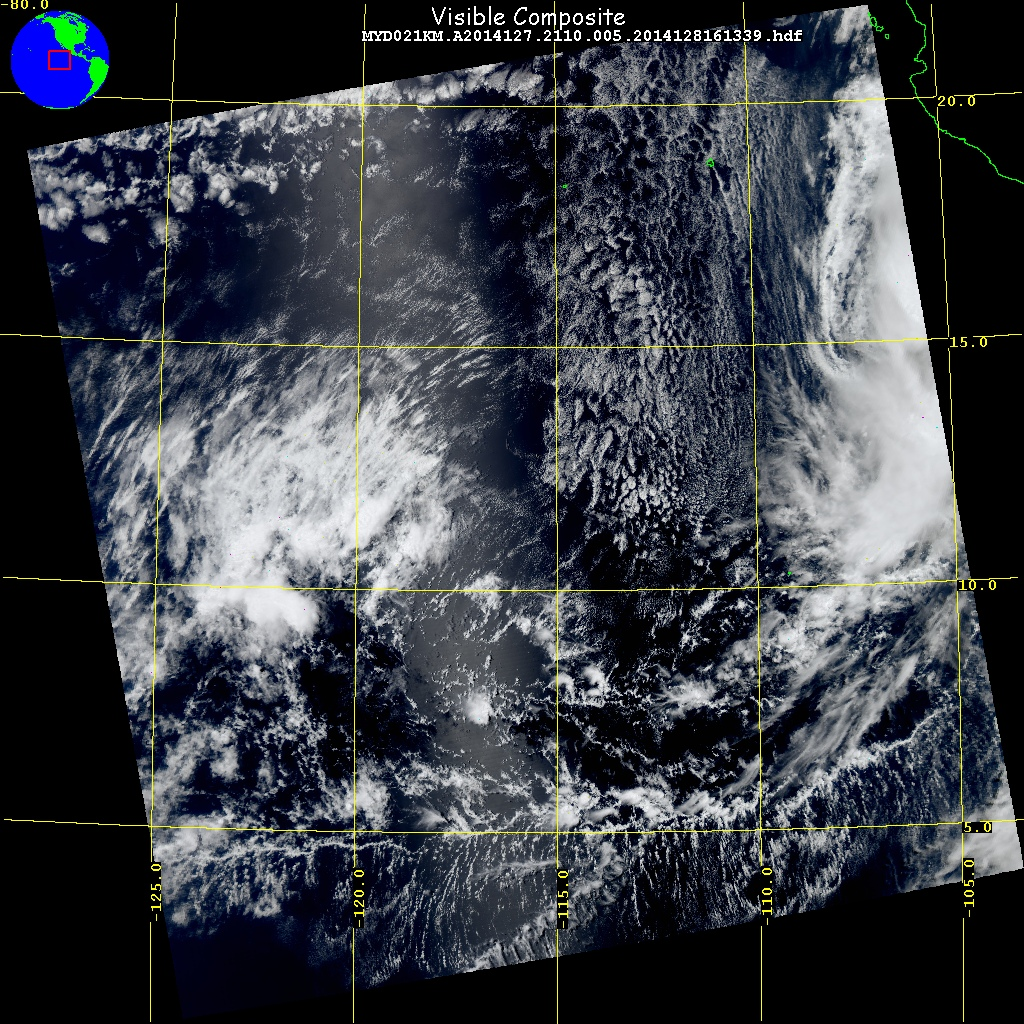

In [89]:
%matplotlib inline
from pathlib import Path
import a212data
picwidth = 800
datadir = a212data.__path__[0]
image_path = Path(datadir).joinpath('MYBRGB.A2014127.2110.005.2014128174940.jpg')
print(str(image_path))
Image(str(image_path),width=picwidth)

Use [h5py](http://docs.h5py.org/en/latest/)   to read the image data

In [90]:
from a212utils.h5dump import dumph5
if download:
    dumph5(local_file)

In [91]:
with h5py.File(local_file,'r') as f:
    file_dict = {}
    vars = ['ch29','ch31','cloud_mask','phase']
    for name in vars:
        fullname = '/A2014127/{}'.format(name)
        file_dict[name] = f[fullname][...]
    file_dict.update(f.attrs.items())

In [92]:
file_dict.keys()

dict_keys(['ch31', 'mask_vals', 'phase', 'phase_vals', 'cloud_mask', 'ch29'])

In [93]:
#
# make a 5 color palette
#
import seaborn as sns
from matplotlib.colors import ListedColormap, LinearSegmentedColormap 
colors = ["royal blue", "baby blue", "eggshell", "burnt red", "soft pink"]
print([the_color for the_color in colors])
colors=[sns.xkcd_rgb[the_color] for the_color in colors]
pal=ListedColormap(colors,N=5)

['royal blue', 'baby blue', 'eggshell', 'burnt red', 'soft pink']


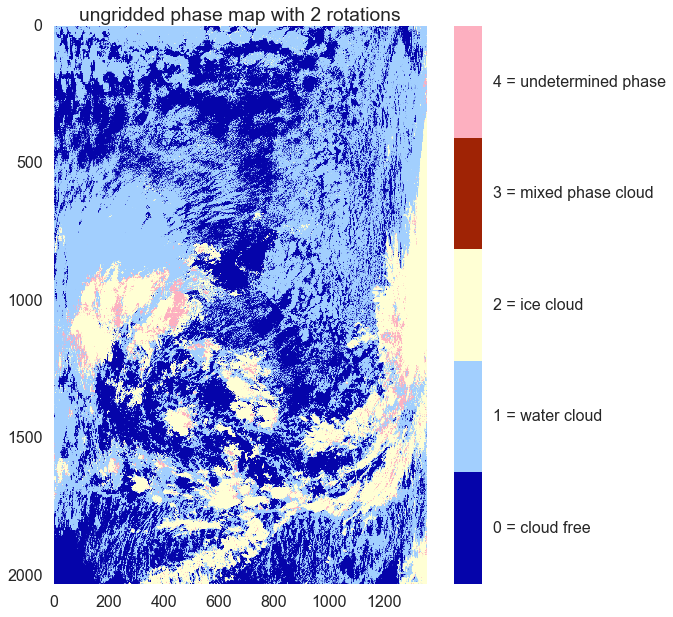

In [94]:
# #
# the A2014127.2110 scene is a descending orbit, so south is on top
# and west is on the right, need to rotate through 180 degrees
#
%matplotlib inline
from matplotlib import pyplot as plt
fig,ax = plt.subplots(1,1,figsize = (10,10))
phase_rot=np.rot90(file_dict['phase'],2)
CS=ax.imshow(phase_rot,cmap=pal)
ax.set_title('ungridded phase map with 2 rotations')
cax=fig.colorbar(CS)
#
# we wrote the phase legend into the h5 attributes
# use it to label the color axis
#
labels=file_dict['phase_vals']
labels=labels.split(',')
ends=np.linspace(0,4,6)
centers=(ends[1:] + ends[:-1])/2.
cax.set_ticks(centers)
cax.set_ticklabels(labels)

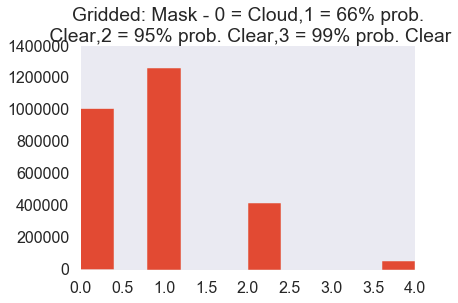

In [95]:
plt.close('all')
fig,ax=plt.subplots(1,1)
ax.hist(phase_rot.ravel())
ax.set_title('Gridded: Mask - 0 = Cloud,1 = 66% prob.\n Clear,2 = 95% prob. Clear,3 = 99% prob. Clear')

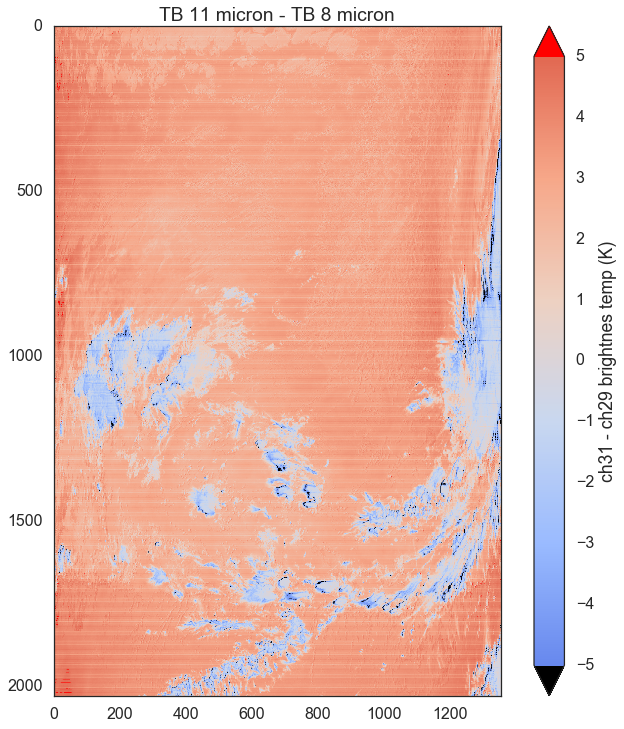

In [112]:
plt.close('all')
from matplotlib.colors import Normalize
from numpy import ma
fig,ax=plt.subplots(1,1,figsize=(12,12))
colors=sns.color_palette('coolwarm')
pal=LinearSegmentedColormap.from_list('test',colors)
pal.set_bad('0.75') #75% grey
pal.set_over('r')
pal.set_under('k')
vmin= -5.
vmax= 5.
ch29 = np.rot90(file_dict['ch29'],2)
ch31 = np.rot90(file_dict['ch31'],2)
the_norm=Normalize(vmin=vmin,vmax=vmax,clip=False)
tdiff= ch31 - ch29
tdiff=ma.array(tdiff,mask=np.isnan(tdiff))
CS= ax.imshow(tdiff,cmap=pal,norm=the_norm)
cax=plt.colorbar(CS,  ax = ax,extend='both')
cax.set_label('ch31 - ch29 brightnes temp (K)')
ax.set_title('TB 11 micron - TB 8 micron')




### For next Tuesday: check in a notebook that

1. Create a pandas Dataframe with 3 columns:  phase, ch29, ch31 using rows
   1100:1500 of the rotated image
   
2. Use groupby on the phase column to collect pixels with the same phase

3. Loop through each of the phases and calculate the mean ch29 and ch 31 values
   for that phase and the mean of the differences.
   
4. Write those results out as a new DataFrame with 5 columns (1 for each phase)
   and 1 row

In [97]:
the_slice=slice(1100,1500)
column_data = dict(phase=phase_rot[the_slice,:].ravel(),ch29=ch29[the_slice,:].ravel(),ch31=ch31[the_slice,:].ravel())

In [98]:
df_satellite = pd.DataFrame(column_data)
out = phase_rot[the_slice,:].ravel()
print(type(out))
list(df_satellite.columns)

<class 'numpy.ndarray'>


['ch29', 'ch31', 'phase']

In [99]:
groups=df_satellite.groupby('phase')
the_groups = list(groups)

In [100]:
chan_dict={}
for value in ['ch29','ch31']:
    chan_dict[value] = {}  
    for phase, group in groups:
        #save the mean for each phase
        chan_dict[value][phase] = group[value].mean()
df_dict={}
for value in ['ch29','ch31']:
    temps=list(chan_dict[value].values())
    names = list(chan_dict[value].keys())
    df_dict[value] = pd.DataFrame.from_records([temps],columns=names)
df_dict['Tdiff'] = df_dict['ch31'] - df_dict['ch29']

In [101]:
df_dict['Tdiff']

,0,1,2,4
0,2.753448,2.61026,-0.594452,0.821838


### For next week

Check in a notebook that:

1) breaks the image into 16 subsets (4 x 4 in rows and columns)

2) write a function that produces a two new data frames for the the ch31 and  ch31 - ch29 mean temperature
   that have a column for each phase and 16 rows, one for each subset.
   
3) Make a scatterplot with 4 symbols (one for each phase) that plots ch31 on the x axis and ch31 - ch29 on the y axis

### 1\. split the image into 16 subscenes and make a dataframe for each subscene

Store the dataframes in the scene_dict, indexed by scene number

In [102]:
rows,cols=file_dict['ch29'].shape
#
# use the modulus function to find the even divisor
#
remainder = np.mod(rows,4)
rows4 = int((rows - remainder)/4.)
remainder = np.mod(cols,4)
cols4 = int((cols - remainder)/4)
left_cols=np.arange(0,4*cols4,cols4,dtype=np.int)
bot_rows = np.arange(0,4*rows4,rows4,dtype=np.int)
scene_dict={}
vars = ['ch29','ch31','phase']
scene=0
#
# go through the 16 subscenes
#
for botrow in bot_rows:
    for leftcol in left_cols:
        scene_dict[scene]={}
        row_slice=slice(botrow,botrow + rows4)
        col_slice=slice(leftcol,leftcol + cols4)
        for var in vars:
            scene_dict[scene][var]=file_dict[var][row_slice,col_slice].ravel()
        df = pd.DataFrame(scene_dict[scene])
        scene_dict[scene]['df']=df
        scene+=1

### 2\. Create a dataframe for each of the 16 subscenes and add to scene_dict

This function finds the mean for each channel and each phase and saves
it in a dictionary keyed by phase.

In [111]:
def calc_means(subscene_df):
    """
    given a subscene dictionary, group by phase and find the
    mean for each phase and channel
    
    Parameters
    ----------
    
    subscene_df: dataframe
    
        dataframe with pixels on rows and columns ['phase','ch29','ch31']
    
    Returns
    -------
    
    phase_dict: dictionary
    
        nested dictionary with the phase as the key and the mean for
        each temperature as another dictionary
    """
    phase_dict={}
    groups=subscene_df.groupby('phase')
    for phase,group in groups:
        phase_dict[phase]={}
        for value in ['ch29','ch31']:
            phase_dict[phase][value]=group[value].mean()
    return phase_dict

Now combine all of the phases for a given channel so that we
can construct a dataframe for each channel with the phase
in the columns

In [110]:
#
# make dictionaries to hold the channel temperatures for each phase
# start with empty list initially and append each subscene mean
#
ch31_dict = {0:[],1:[],2:[],3:[],4:[]}
ch29_dict = {0:[],1:[],2:[],3:[],4:[]}
for subscene,the_dict in scene_dict.items():
    #
    # find the average temperature for each phase in the subscne
    #
    phase_dict=calc_means(the_dict['df'])
    for phase in range(5):
        try:
            ch31_dict[phase].append(phase_dict[phase]['ch31'])
            ch29_dict[phase].append(phase_dict[phase]['ch29'])
        except KeyError:
            #
            # if the phase doesn't occur in the scene, need to
            # add np.nan as a placeholder
            #
            ch31_dict[phase].append(np.nan)
            ch29_dict[phase].append(np.nan)
df_31=pd.DataFrame(ch31_dict)
df_29 = pd.DataFrame(ch29_dict)
df_diff = df_31 - df_29      
df_diff
            

,0,1,2,3,4
0,3.403198,3.248352,-0.760986,NaN,0.777863
1,2.996521,2.830841,-0.635803,NaN,0.906738
2,2.897522,2.598694,-0.554688,NaN,0.956757
3,3.485107,3.125000,-0.381531,NaN,0.995636
4,3.157593,2.842865,-0.804703,NaN,0.759933
5,2.968597,2.825684,-0.538300,NaN,0.816071
6,2.527740,2.391144,-0.233398,NaN,0.714844
7,2.570221,2.520233,-0.897064,NaN,0.886597
8,3.362122,3.165588,-1.474304,NaN,1.062927
9,3.046021,2.835968,1.236664,NaN,1.424133


### 3\. Make the plots

Choose a differnt color and shape for each phase, plot
as a scatterplot (linestyle = 'None')

* Useful web pages: 

  - [plot command options](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.plot)
  
  - [Matplotlib style gallery](https://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html)





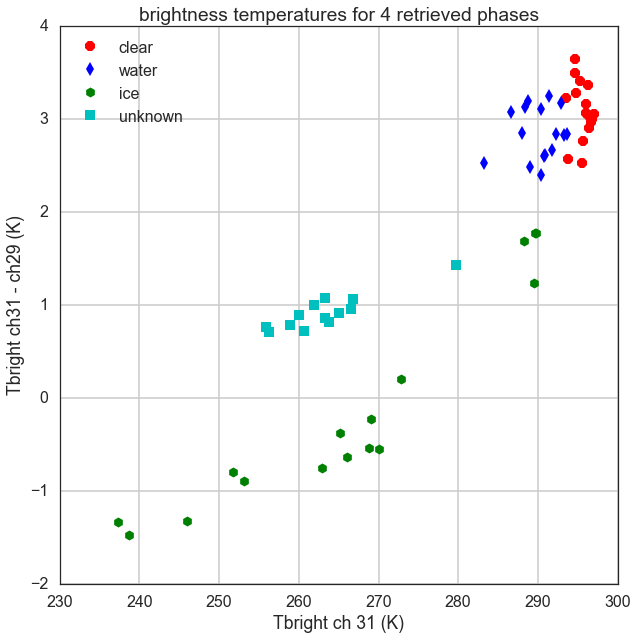

In [109]:
plt.style.use('seaborn-white')
plt.close('all')
color_cycle =['r','b','g','c']
symbol_cycle = ['8','d','h','s']
phases = [0,1,2,4]
legend={0:'clear',1:'water',2:'ice',4:'unknown'}
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.grid()
for phase,symbol,color in zip(phases,symbol_cycle,color_cycle):
    ax.plot(df_31[phase],df_diff[phase],
                   marker=symbol,mec='k',mfc=color,ls='None',ms=10,label=legend[phase])
ax.legend(loc='best')
out=ax.set(xlabel='Tbright ch 31 (K)',ylabel='Tbright ch31 - ch29 (K)',
      title='brightness temperatures for 4 retrieved phases')